## This script is used to check the mocks we use

### Current version -- AbacusHF-v1: 

box_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Boxes/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

cutsky_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Cutsky/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

forclustering_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Cutsky/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

In [29]:
import sys
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table,join,Column
from cosmoprimo.fiducial import DESI, AbacusSummit

from scipy.interpolate import interp1d

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_ABACUSHF_v1
from helper import CSPEED, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER

ABACUSHF_DIR = f'/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0'
LOCAL_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

BOXSIZE = 2000

In [33]:
tracer = 'QSO'
z= REDSHIFT_ABACUSHF_v1[tracer][0]

mock_id = '024'

# data_fn = ABACUSHF_DIR+ '/AbacusSummit_base_c000_ph000/Boxes/LRG/abacus_HF_LRG_0p500_DR2_v1.0_AbacusSummit_base_c000_ph000_clustering.dat.fits'
cubic_name = f'/abacus_HF_{tracer}_{zfmt(z)}_DR2_v1.0_AbacusSummit_base_c000_ph{mock_id}_clustering.dat.fits'
data_fn = LOCAL_DIR+ f'/Boxes/{tracer}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}'+cubic_name
data = Table.read(data_fn)
print(data_fn)
data

/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph024/abacus_HF_QSO_1p400_DR2_v1.0_AbacusSummit_base_c000_ph024_clustering.dat.fits


X,Y,Z,VX,VY,VZ,HALO_MASS,HALO_ID,IS_CENTRAL,X_RSD,Y_RSD,Z_RSD,VZ_OBS,Z_OBS
float64,float64,float64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64
-999.00390625,-999.2971801757812,-839.4910888671875,-81.90771390117234,-344.9012281714939,-185.59817117417256,1855991737998.6956,135000000,True,1000.1208617945884,997.0173479439925,1158.52568583521,-221.4149760047613,1158.14296227188
-999.1339721679688,-999.0342407226562,-840.1600952148438,-81.70854368315405,-130.22244309155084,-93.0417135869797,1550174917533.0012,135000001,True,999.9929241271967,999.5742561077765,1158.845699513894,112.91897427091534,1161.046510243263
-999.3583984375,-999.9343872070312,-838.9761352539062,112.91958753060645,130.61187790887126,-42.90867859883034,2246171819282.512,136000000,True,1001.8482135736461,1001.4612773019318,1160.5653603527285,-24.200614544752867,1160.765266987942
-999.5144653320312,999.9669799804688,-825.6743774414062,16.51369821243185,-42.233978014009615,253.38668843281562,1661956238117.0137,147000000,True,1000.6619932173428,999.5156851585108,1177.0332079156933,254.11740869327923,1177.0410160901858
-999.4752197265625,999.87890625,-413.7838134765625,-6.847110767078323,97.88945230046875,201.3118324043857,868941586426.662,498000000,True,1000.4516148796039,1000.92491245223,1588.3673215061008,-66.3175163952044,1585.5075449707915
-999.1387939453125,-999.70458984375,446.8309020996094,-503.3582196901734,-20.664028302472502,432.0632219828883,1605011037064.781,1230001000,True,995.4825282976269,1000.0746028960244,451.4477509973064,420.3097545467006,451.32215830527434
-999.6165161132812,-998.5692749023438,601.712158203125,636.9139012236868,412.6607187365966,-421.7499436655839,3954527850849.493,1361001000,True,1007.189282420779,1005.8402468701374,597.2055127321681,-342.36399167174653,598.0537981827865
-999.2142944335938,-999.4296264648438,602.0073852539062,-256.4491542556561,815.6145961962056,-246.80666567761423,2809296585243.48,1361001001,True,998.0453959660963,1009.2856937887815,599.3701112986074,-617.1421102390409,595.4128599011042
-998.9811401367188,-999.6985473632812,652.2261962890625,-457.5823058405437,268.87089198839385,-30.737701994940632,1670392564198.826,1404000000,True,996.1293245896466,1003.1744957890669,651.8977459180223,-57.36555042686461,651.6132117424062


## Add redshift errros to catalogs

In [6]:
GLOBAL_SEED = 123

def sample_from_cdf(cdf_fn, Ngal, vmode, seed=123):
    """Load the |dv| CDF and sample dv."""
    np.random.seed(seed)
    data = np.load(cdf_fn, allow_pickle=True)
    grid = data["grid"]
    cdf  = data["cdf"]
    cdf_unique, ind = np.unique(cdf, return_index=True)
    grid_unique = grid[ind]
    inv_cdf = interp1d(
        cdf_unique / cdf_unique[-1],
        grid_unique,
        bounds_error=False,
        fill_value=(grid_unique[0], grid_unique[-1]),
        kind='linear'
    )
    if 'log' in vmode:
        if 'abs' in vmode:
            u = np.random.uniform(0, 1, int(Ngal / 2))
            y = inv_cdf(u)
            dv = np.append(10**y, -10**y)
            if Ngal % 2 == 1:
                dv = np.append([0.0], dv)
            np.random.shuffle(dv)
        elif 'signed' in vmode:
            u = np.random.uniform(0, 1, int(Ngal))
            dv = 10**inv_cdf(u)
    elif 'linear' in vmode:
        u = np.random.uniform(0, 1, int(Ngal))
        dv = inv_cdf(u)
    return dv, inv_cdf

def model_dv_from_cdf(tracer, z1, z2, N, cdf_kind = 'obsCDF', vmode = 'log_signed', seed=123):
    """Return dv_model array for a given mode and (tracer, z-bin).
    dv_real:
        Real dv_real distribution
    
    vmode : {"log-signed", "log-abs", "linear"}, optional
        Controls how the Δv distribution is modeled. Supported options

    cdf_kind : {"KCDF", "obsCDF"}, optional
        Which CDF(s) to use:
            - "LCDF" : kernel-smoothed CDF
            - "obsCDF"  : observed CDF (histogram-based)
    -----
    return 
    dv redshift errros distribution
    """
    if vmode == "log_abs":
        fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode, seed)
        return np.asarray(dv_model, float)
    elif vmode == "log_signed":
        (_N, _p, _n) = GET_REPEATS_NUMBER(tracer, z1, z2)
        N_p = int(N*float(_p/_N))
        N_n = N-N_p
        dv_model_list = []
        for sign, Num in [('+', N_p), ('-', N_n)]:
            fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}_{sign}.npz"
            sample, _ = sample_from_cdf(fn, Num, vmode, seed)
            sample = np.asarray(sample, float)
            dv_model_list.append(sample if sign=='+' else -sample)
        dv_model = np.concatenate(dv_model_list)
        np.random.shuffle(dv_model)
        return np.asarray(dv_model, float)
    elif vmode == "linear":
        fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode, seed)
        return np.asarray(dv_model, float)
    else:
        raise ValueError(f"Unknown mode: {vmode}")


In [34]:
dv = model_dv_from_cdf('LRG', 0.4, 1.1, len(data), seed = GLOBAL_SEED)

dv

array([-5.93665693, 25.54365249, 23.70330826, ..., 60.37915493,
       83.03277362, -4.15939623])

In [ ]:
data['VZ_OBS'] = data['VZ'] + dv

cosmo = DESI()
Hz = cosmo.H0 * cosmo.efunc(z)/cosmo.h

data['Z_OBS']=(data['Z_RSD']+dv*(1+z)/Hz) %BOXSIZE

In [ ]:
(data['Z_OBS'])

9.097974959192123e-05

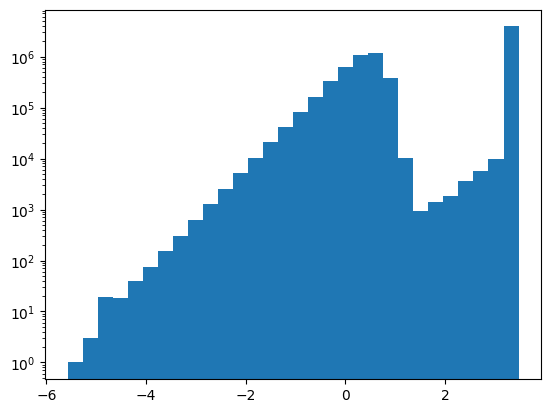

In [ ]:
# plt.hist(np.log10(abs(data['VZ_obs'] - data['VZ'])), bins=20)
plt.hist(np.log10(abs(data['Z_OBS'] - data['Z'])), bins=30)
plt.yscale('log')

## Check the Cutsky mocks

In [42]:
tracer = 'ELG'
z = REDSHIFT_ABACUSHF_v1[tracer][0]
tracer_type = TRACER_CUTSKY_INFO[tracer]['tracer_type']
fit_range   = TRACER_CUTSKY_INFO[tracer]['fit_range']

mock_id = '000'
cutsky_name = f'cutsky_abacusHF_DR2_{tracer}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
data_fn = LOCAL_DIR+ f'/Cutsky/{tracer_type}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
data = Table.read(data_fn)
data

RA,DEC,TRUEZ,STATUS,RAW_NZ,RAN_NUM_0_1,NZ,Z,HALO_ID,HALO_MASS,IS_CENTRAL,NZ_LOP,RAN_NUM_0_1_LOP,WEIGHT,DESI_TARGET,PRIORITY_INIT,PRIORITY,NUMOBS_MORE,NUMOBS_INIT,BGS_TARGET,TARGETID,MWS_TARGET,SUBPRIORITY,BRICKNAME,OBSCONDITIONS,SCND_TARGET,ZWARN
float32,float32,float32,int32,float32,float32,float32,float32,int64,float32,bool,float32,float32,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes8,int64,int64,int64
217.34549,3.3733292,1.1414845,47,0.0030449745,0.033220068,0.00091313646,1.1412414,85012530976000000,288944160000.0,True,0.787151,0.09106902,1.0,66,3100,3100,2,2,0,3400021830,0,0.879118893248083,000p0000,1,0,0
217.29918,2.552597,1.1394222,47,0.0030449745,0.2855139,0.00091619074,1.1377382,85012550945000992,423925380000.0,True,0.7839544,0.62208945,1.0,66,3100,3100,2,2,0,3400021831,0,0.95163214168708,000p0000,1,0,0
217.26936,0.35697174,1.1368638,47,0.0030449745,0.14053808,0.00091997965,1.136978,85012570863000000,305816800000.0,True,0.77998894,0.41029212,1.0,66,3100,3100,2,2,0,3400021832,0,0.5524714787514492,000p0000,1,0,0
217.20569,4.776764,1.141816,47,0.0030449745,0.11745484,0.0009126455,1.1417729,85012601028000000,670687900000.0,True,0.78766483,0.25744212,1.0,66,3100,3100,2,2,0,3400021833,0,0.8082665322069504,000p0000,1,0,0
217.13632,1.6860733,1.1348774,47,0.0030449745,0.11902585,0.0009229402,1.1333437,85012630913002000,457670700000.0,True,0.7770779,0.34194925,1.0,66,3100,3100,2,2,0,3400021834,0,0.2931481585217385,000p0000,1,0,0
217.13225,4.9381866,1.1404338,47,0.0030449745,0.22754051,0.0009146926,1.1415235,85012631034000000,191926420000.0,True,0.7855224,0.5989359,1.0,66,3100,3100,2,2,0,3400021835,0,0.6674423322632848,000p0000,1,0,0
216.93158,3.1077118,1.1326433,47,0.0030449745,0.05218533,0.0009265896,1.1319121,85012720965002000,324798550000.0,True,0.7766758,0.57248217,1.0,66,3100,3100,2,2,0,3400021836,0,0.13492659873662038,000p0000,1,0,0
216.88524,3.3636398,1.1319985,47,0.0030449745,0.23947215,0.00092764286,1.1313535,85012740974000000,512506800000.0,True,0.7765597,0.24219933,1.0,66,3100,3100,2,2,0,3400021837,0,0.3788918028746382,000p0000,1,0,0
217.27655,1.4968948,1.1375828,47,0.0030449745,0.2693026,0.0009189149,1.1351339,85112570906000000,333234860000.0,True,0.7811033,0.63718915,1.0,66,3100,3100,2,2,0,3400021838,0,0.14435515855856484,000p0000,1,0,0


In [39]:
data_fn

'/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/ELG/z0.950/AbacusSummit_base_c000_ph000/forclustering/cutsky_abacusHF_DR2_ELG_z0p950_zcut_0p8to1p6_clustering.dat.fits'

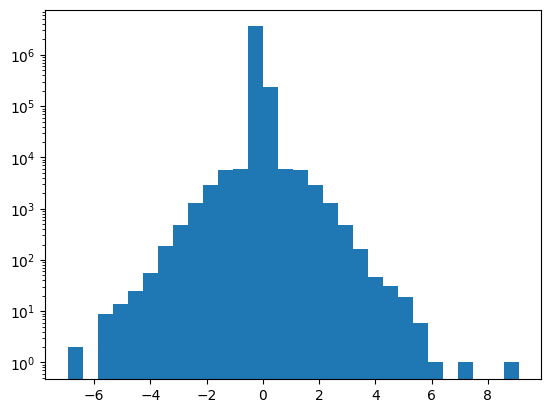

In [7]:
plt.hist(data['Z_OBS_GLOBAL'] - data['Z_OBS_BIN'], bins=30,)
plt.yscale('log')

-4.903413267274242

## Check the n(z)

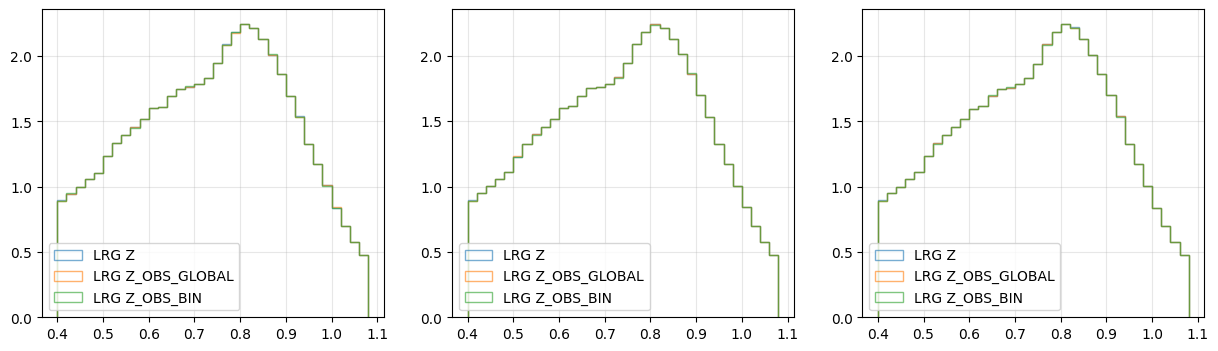

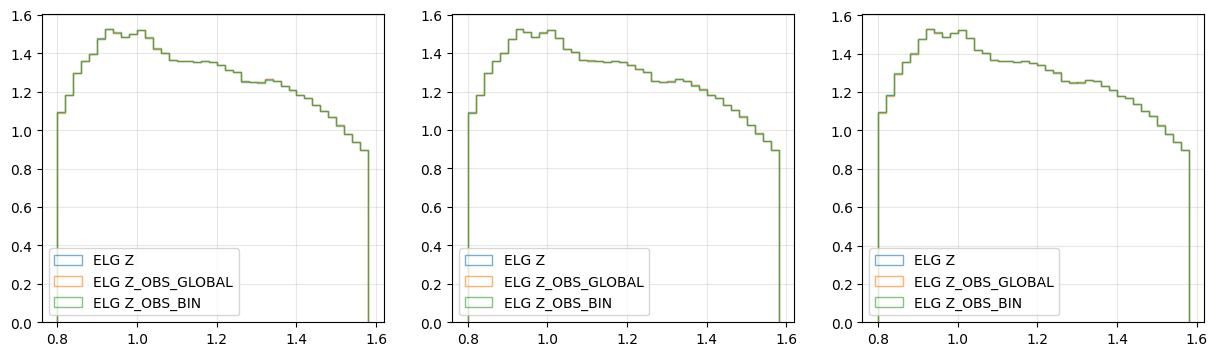

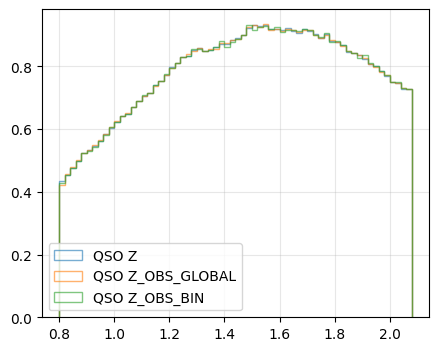

: 

In [ ]:
# load the data
tracers = ['LRG','ELG','QSO']
mock_id = '000'

for i, tracer in enumerate(tracers):
    lenf = len(REDSHIFT_ABACUSHF_v1[tracer])
    tracer_type = TRACER_CUTSKY_INFO[tracer]['tracer_type']
    fit_range   = TRACER_CUTSKY_INFO[tracer]['fit_range']
    (zmin, zmax) = REDSHIFT_BIN_OVERALL[tracer]
    fig = plt.figure(figsize = (lenf*5, 4))
    gs = gridspec.GridSpec(1, lenf, wspace=0.2, hspace=0.25)
    for indz, z in enumerate(REDSHIFT_ABACUSHF_v1[tracer]):
        ax = fig.add_subplot(gs[indz]) 
        cutsky_name = f'cutsky_abacusHF_DR2_{tracer_type}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
        data_fn = LOCAL_DIR+ f'/Cutsky/{tracer_type[:3]}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
        data = Table.read(data_fn)
        bins = np.arange(zmin, zmax, 0.02)
        for Zcol in ['Z', 'Z_OBS_GLOBAL', 'Z_OBS_BIN']:
            plt.hist(data[Zcol],  bins=bins, alpha=0.6, histtype='step', density =True, label = f'{tracer} {Zcol}')
        ax.legend(loc=3, fontsize=10)
        ax.grid(True, alpha=0.3)

## Check the randoms

In [7]:
dir = '/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/randoms/raw'
ran_fn = dir+'/rands_intiles_DARK_13_NO_imagingmask_withz.fits'
random = Table.read(ran_fn)

In [8]:
random

RA,DEC,BRICKNAME,BRICKID,NOBS_G,NOBS_R,NOBS_Z,MASKBITS,Z_LRG,WEIGHT,Z_QSO,Z_ELG_LOP,ELG_LOP_MASK
float64,float64,bytes8,int32,int16,int16,int16,int16,float32,float64,float32,float32,bool
131.10538101204935,32.580423683787615,1310p325,508477,3,3,3,0,0.77780396,1.0,1.1159618,1.430006,True
132.35314330662587,67.53484652698316,1322p675,636627,4,4,5,0,0.45066065,1.0,2.7317574,1.413694,True
109.12629815313427,67.36941701620609,1089p672,636033,1,1,2,0,0.8693832,1.0,1.8262906,1.329749,True
150.90882470846006,61.503105569541056,1510p615,621681,4,3,2,0,0.75413436,1.0,1.3158114,1.3399308,False
100.8179628761383,50.86060920702921,1006p507,586917,3,3,5,0,0.66115665,1.0,1.1601838,0.99419767,True
286.6414044163633,70.42736593856144,2867p705,643083,3,3,4,0,0.65461475,1.0,1.025111,1.2241855,True
115.00608504685084,72.59049201008268,1146p725,646541,5,5,4,0,0.7521567,1.0,0.9810398,1.0116175,True
245.1509138359624,54.56238162488465,2453p545,600434,5,4,4,0,0.5478665,1.0,2.7572043,0.8048313,True
106.84595161268317,55.93351177813055,1067p560,605063,3,3,5,0,0.49455103,1.0,1.1798683,0.8952286,True


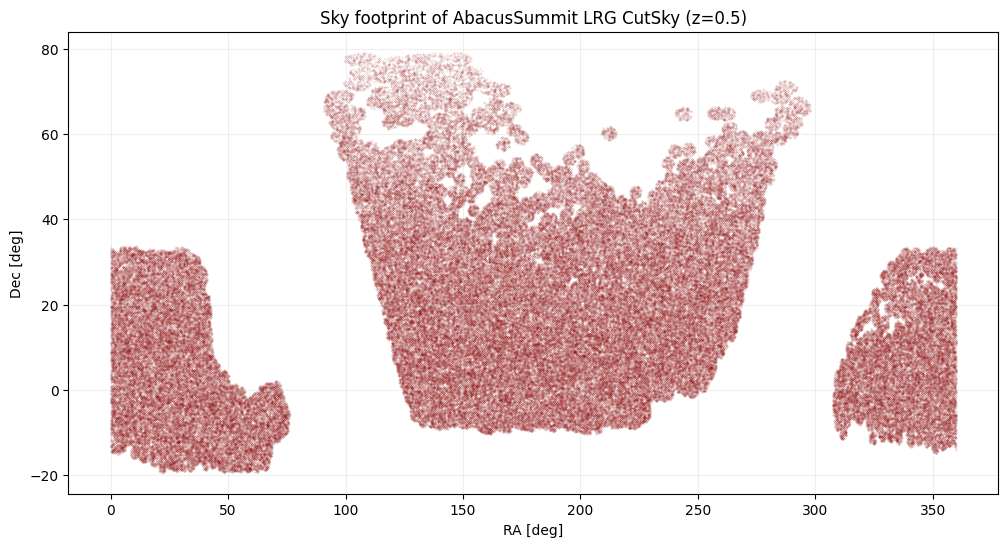

In [ ]:
# Extract coordinates
ra = np.asarray(data['RA'])
dec = np.asarray(data['DEC'])

# If the catalog is huge, downsample for speed
idx = np.random.choice(len(ra), size=200000, replace=False)  # sample 2e5 points
ra, dec = ra[idx], dec[idx]

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(ra, dec, s=0.05, color='darkred', alpha=0.3)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('Sky footprint of AbacusSummit LRG CutSky (z=0.5)')
plt.grid(alpha=0.2)
plt.show()

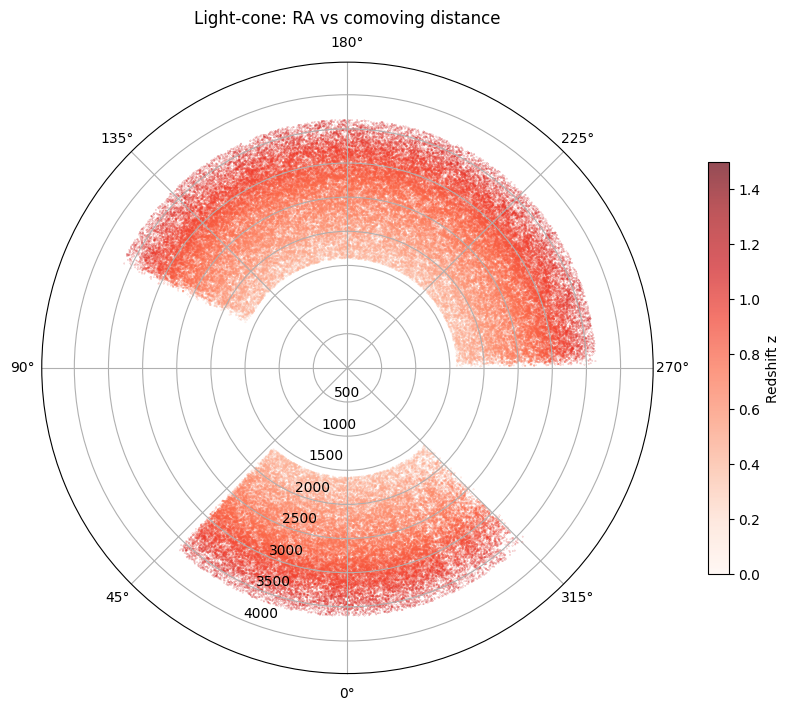

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from astropy.cosmology import Planck18 as cosmo

dec_band_halfwidth = 5.0
max_points = 200000
zmax = 1.5

ra  = np.asarray(data['RA'], dtype=float)
dec = np.asarray(data['DEC'], dtype=float)
z   = np.asarray(data['Z'],  dtype=float)

dec0 = np.nanmedian(dec)
sel = np.isfinite(z) & (dec > dec0 - dec_band_halfwidth) & (dec < dec0 + dec_band_halfwidth) & (z < zmax)
idx = np.where(sel)[0]
if idx.size > max_points:
    idx = np.random.choice(idx, size=max_points, replace=False)

theta = np.radians(ra[idx])
r = cosmo.comoving_distance(z[idx]).value  # Mpc
rmax = cosmo.comoving_distance(zmax).value

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

norm = Normalize(vmin=0.0, vmax=zmax)     # fixes colorbar range
sc = ax.scatter(theta, r, s=0.02, c=z[idx], cmap='Reds', norm=norm, alpha=0.7)

ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_rmin(0); ax.set_rmax(rmax)
ax.set_title('Light-cone: RA vs comoving distance', va='bottom')

cb = plt.colorbar(sc, pad=0.08, fraction=0.03, shrink=0.8)
cb.set_label('Redshift z')

plt.tight_layout()
plt.show()

## APPENDIX

In [11]:
# random length 

for tracer in ['LRG','ELG', 'QSO']:
    for z in REDSHIFT_ABACUSHF_v1[tracer]:
        if tracer == 'LRG':
            tracer_type = 'LRG'
            fit_range = '0p4to1p1'
        elif tracer == 'ELG':
            tracer_type = 'ELG_LOP'
            fit_range = '0p8to1p6'
        elif tracer == 'QSO':
            tracer_type = 'QSO'
            fit_range = '0p8to3p5'
        cutsky_name = f'cutsky_abacusHF_DR2_{tracer_type}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
        data_fn = LOCAL_DIR+ f'/Cutsky/{tracer[:3]}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
        data = Table.read(data_fn)
        print(tracer, z, '\t', 10/(32943255/len(data)))

LRG 0.5 	 2.189337088882079
LRG 0.725 	 2.1897857391444773
LRG 0.95 	 2.1889807185112704
ELG 0.95 	 6.5250835110252465
ELG 1.175 	 6.524094841265685
ELG 1.475 	 6.524465782145692
QSO 1.4 	 1.1704738951873455


179.09605747548974


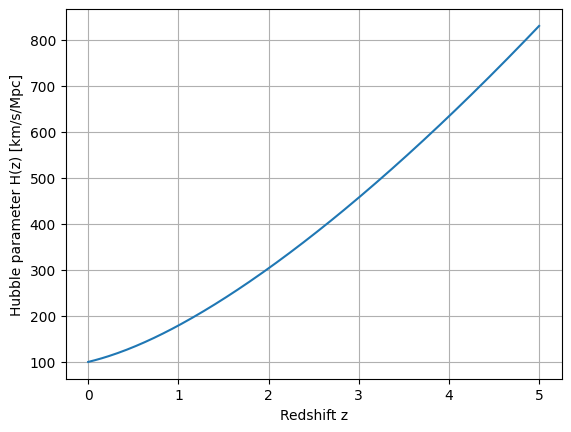

In [60]:
from cosmoprimo.fiducial import DESI, AbacusSummit
import astropy.units as u

# Define redshift range
z = np.linspace(0, 5, 200)

# Load DESI fiducial cosmology
cosmo = DESI()

# Compute H(z)
H_z = cosmo.H0 * cosmo.efunc(z)/cosmo.h   # units: km/s/(Mpc/h)
print(cosmo.H0 * cosmo.efunc(1.0)/ cosmo.h) 
plt.plot(z, H_z)
plt.xlabel("Redshift z")
plt.ylabel("Hubble parameter H(z) [km/s/Mpc]")
plt.grid(True)
plt.show()

In [ ]:
(zmin, zmax) = REDSHIFT_BIN_OVERALL[tracer]
dv = model_dv_from_cdf(tracer, zmin, zmax, len(data))
data['Z_OBS_GLOBAL'] = data['Z']+dv/CSPEED*(1+data['Z'])

data['Z_OBS_BIN'] = data['Z'].copy()
step = 0.1
zrange = np.round(np.arange(zmin, zmax+ step/2, step), 1)
zbins = list(zip(zrange[:-1], zrange[1:]))
for indz, (z1, z2) in enumerate(zbins):
    sel = (data['Z'] >= z1) & (data['Z'] < z2)
    z_sel = data['Z'][sel]
    dv_bin = model_dv_from_cdf(tracer, zmin, zmax, len(z_sel))
    data['Z_OBS_BIN'][sel] = z_sel + dv_bin / CSPEED * (1.0 + z_sel)
    # print(z1, z2)